##### Copyright 2018 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## PR-AUC , ROC-AUC, Precision at Recall, Recall at Precision Maximization
In this colab, we'll show how to use the TF Constrained Optimization (TFCO) library to train a model to maximize the *Area Under the Precision-Recall Curve (PR-AUC)*. We'll show how to train the model both with (i) plain TensorFlow (in eager mode), and (ii) with a custom tf.Estimator.

We start by importing the relevant modules.

In [9]:
# Tensorflow constrained optimization library
!pip install tensorflow-constrained-optimization
#!pip install tensorflow

  Using cached tensorflow_constrained_optimization-0.2-py2.py3-none-any.whl (143 kB)


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn import metrics
from sklearn import model_selection
import tensorflow.compat.v2 as tf

In [11]:
import tensorflow_constrained_optimization as tfco

## Staffing

We will use the School Staffing dataset from the Indian Human Development Survey - II  (School Staffing and Medical Staffing) repository for our illustration. This dataset contains various demographic, religion and racial distribution details (aggregated from human development survey related data sources) about different communities in the India, along with the their age, position and level of education.


We begin by downloading and preprocessing the dataset.

In [12]:
dataset_path = "data/staffing-teaching/School-Staff-Data.csv"

# Read dataset from  https://www.researchconnections.org/icpsrweb/instructors/studies/36151 repository and assign column names.
data_df = pd.read_csv(dataset_path)
data_df.head()

,STATEID,DISTID,PSUID,SCHOOLID,SQGOVT,SS1,SS3,SS4,SS5,SS6,SS7,SS8,SS9,SS10,SS11,SS12,SS13
0,1,2,1,1,1,1,1,1,5,1,1,25,15,1,2,3,2
1,1,2,1,1,1,2,2,3,5,1,2,26,15,1,2,3,2
2,1,2,1,1,1,3,3,3,99,1,2,35,0,,2,5,0
3,1,2,1,2,2,1,1,3,2,2,2,25,15,0,2,3,4
4,1,2,1,2,2,2,2,1,2,1,2,21,15,0,2,3,1


In [13]:
data_df = data_df.dropna()

In [14]:
# List of column names in the dataset.
cols = data_df.columns

In [15]:
data_df.size

543898

In [17]:
for col in data_df.select_dtypes(include=[object]):

    data_df['org_'+col] =  data_df[col]
    data_df[col] = data_df[col].astype('category').cat.codes
    data_df[col] = data_df[col].astype(float)
    print(col)
    print(dict(zip( data_df['org_'+ col], data_df[col] ) ))


data_df = data_df[cols]
data_df.head(10)

SS1
{'1': 1.0, '2': 12.0, '3': 23.0, '4': 34.0, '5': 42.0, '6': 43.0, '7': 44.0, '8': 45.0, '9': 46.0, '10': 2.0, '11': 3.0, '12': 4.0, '13': 5.0, '14': 6.0, '15': 7.0, '16': 8.0, '17': 9.0, '18': 10.0, '19': 11.0, '20': 13.0, '21': 14.0, '22': 15.0, '23': 16.0, '24': 17.0, '25': 18.0, '26': 19.0, '27': 20.0, '28': 21.0, '29': 22.0, '30': 24.0, '31': 25.0, '32': 26.0, '33': 27.0, '34': 28.0, '35': 29.0, '36': 30.0, '37': 31.0, '38': 32.0, '39': 33.0, '40': 35.0, '41': 36.0, '42': 37.0, '43': 38.0, '44': 39.0, '45': 40.0, '46': 41.0, ' ': 0.0}
SS3
{'1': 1.0, '2': 2.0, '3': 3.0, '5': 5.0, '4': 4.0, ' ': 0.0}
SS4
{'1': 1.0, '3': 3.0, '2': 2.0, ' ': 0.0}
SS5
{'5': 9.0, '99': 15.0, '2': 5.0, '4': 8.0, '3': 7.0, '8': 13.0, '6': 11.0, '1': 1.0, '10': 2.0, '55': 10.0, '12': 4.0, '9': 14.0, '7': 12.0, ' ': 0.0, '11': 3.0, '22': 6.0}
SS6
{'1': 1.0, '2': 2.0, ' ': 0.0, '3': 3.0}
SS7
{'1': 1.0, '2': 2.0, ' ': 0.0}
SS8
{'25': 12.0, '26': 13.0, '35': 22.0, '21': 8.0, '32': 19.0, '27': 14.0, '24': 11

,STATEID,DISTID,PSUID,SCHOOLID,SQGOVT,SS1,SS3,SS4,SS5,SS6,SS7,SS8,SS9,SS10,SS11,SS12,SS13
0,1,2,1,1,1,1.0,1.0,1.0,9.0,1.0,1.0,12.0,4.0,2.0,2.0,3.0,13.0
1,1,2,1,1,1,12.0,2.0,3.0,9.0,1.0,2.0,13.0,4.0,2.0,2.0,3.0,13.0
2,1,2,1,1,1,23.0,3.0,3.0,15.0,1.0,2.0,22.0,1.0,0.0,2.0,5.0,1.0
3,1,2,1,2,2,1.0,1.0,3.0,5.0,2.0,2.0,12.0,4.0,1.0,2.0,3.0,35.0
4,1,2,1,2,2,12.0,2.0,1.0,5.0,1.0,2.0,8.0,4.0,1.0,2.0,3.0,2.0
5,1,2,2,1,1,1.0,1.0,1.0,9.0,1.0,1.0,22.0,5.0,2.0,2.0,2.0,43.0
6,1,2,2,1,1,12.0,2.0,2.0,9.0,1.0,2.0,19.0,5.0,2.0,2.0,2.0,2.0
7,1,2,2,2,2,1.0,1.0,1.0,9.0,1.0,1.0,14.0,4.0,2.0,2.0,2.0,1.0
8,1,2,2,2,2,12.0,2.0,3.0,9.0,1.0,1.0,11.0,4.0,2.0,2.0,2.0,1.0
9,1,2,2,2,2,23.0,2.0,3.0,9.0,1.0,1.0,21.0,3.0,1.0,2.0,2.0,1.0


In [18]:
data_df['SS9'] = data_df['SS9'].astype(int)
data_df['SS9'] = np.where((data_df['SS9'] != 5), 0, 1)
data_df['SS9'].unique()

array([0, 1])

In [19]:
labels_df = data_df['SS9'].astype(int)


In [20]:
labels_df

0        0
1        0
2        0
3        0
4        0
        ..
31989    0
31990    0
31991    0
31992    0
31993    0
Name: SS9, Length: 31994, dtype: int64

In [21]:
data_df.size

543898

We encode all categorical columns, and use other numerical/boolean features.

In [22]:
data_df.columns

Index(['STATEID', 'DISTID', 'PSUID', 'SCHOOLID', 'SQGOVT', 'SS1', 'SS3', 'SS4',
       'SS5', 'SS6', 'SS7', 'SS8', 'SS9', 'SS10', 'SS11', 'SS12', 'SS13'],
      dtype='object')

In [23]:
cols = data_df.columns

Some of the numerical columns contain missing values (denoted by a NaN). For each feature that has at least one value missing, we append an additional boolean "is_missing" feature indicating that the value was missing, and fill the missing value with 0.

In [24]:
feature_names = data_df.columns
for feature_name in feature_names:  
    # Which rows have missing values?
    missing_rows = data_df[feature_name].isna()
    if missing_rows.any():  # Check if at least one row has a missing value.
        data_df[feature_name].fillna(0.0, inplace=True)  # Fill NaN with 0.
        missing_rows.rename(feature_name + "_is_missing", inplace=True)
        data_df = data_df.join(missing_rows)  # Append "is_missing" feature.

Finally, we divide the dataset randomly into two-thirds for training and one-thirds for testing.

In [25]:
# Set random seed so that the results are reproducible.
np.random.seed(123456)

# Train and test indices.
train_indices, test_indices = model_selection.train_test_split(
    np.arange(data_df.shape[0]), test_size=1./3.)

# Train and test data.
x_train_df = data_df.loc[train_indices].astype(np.float32)
y_train_df = labels_df.loc[train_indices].astype(np.float32)
x_test_df = data_df.loc[test_indices].astype(np.float32)
y_test_df = labels_df.loc[test_indices].astype(np.float32)

# Convert data frames to NumPy arrays.
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values

In [26]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [27]:
np.unique(y_test)

array([0., 1.], dtype=float32)

# (1a)  PR-AUC Training with Plain TF

In [28]:
batch_size = 128  # first fix the batch size for mini-batch training


We will work with a linear classification model and define the data and model tensors. 


In [29]:
# Create linear Keras model.
layers = []
layers.append(tf.keras.Input(shape=(x_train.shape[-1],)))
layers.append(tf.keras.layers.Dense(32, activation='relu')) 
layers.append(tf.keras.layers.Dense(32, activation='relu')) 
layers.append(tf.keras.layers.Dense(1))
model = tf.keras.Sequential(layers)

# Create nullary functions that return labels and logits from the current
# batch. In eager mode, TFCO requires these to be provided via nullary function.
# We will maintain a running array of batch indices.
batch_indices = np.arange(batch_size)
labels_fn = lambda: tf.constant(y_train[batch_indices], dtype=tf.float32)
logits_fn = lambda: model(x_train[batch_indices, :])

We next set up the constraint optimization problem to optimize PR-AUC.


In [30]:
# Create context with labels and predictions.
context = tfco.rate_context(logits_fn, labels_fn)

# Create optimization problem with PR-AUC as the objective. The library
# expects a minimization objective, so we negate the PR-AUC. 

# We use the pr_auc rate helper which uses a Riemann approximation to the area 
# under the precision-recall curve (recall on the horizontal axis, precision on 
# the vertical axis). We would need to specify the the number of bins 
# ("rectangles") to use for the Riemann approximation. We also can optionally
# specify the surrogate to be used to approximate the PR-AUC.
pr_auc_rate = tfco.pr_auc(
    context, bins=10, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
problem = tfco.RateMinimizationProblem(-pr_auc_rate)

We then create a loss function from the `problem` and optimize it to train the model.

In [31]:
# Create Lagrangian loss for `problem`. What we get back is a loss function, a 
# a nullary function that returns a list of update_ops that need to be run 
# before every gradient update, and the Lagrange multiplier variables internally
# maintained by the loss function. The argument `dual_scale` is a 
# hyper-parameter that specifies the relative importance placed on updates on 
# the Lagrange multipliers.
loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
    problem, dual_scale=1.0)

# Set up optimizer and the list of variables to optimize.
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
var_list = (model.trainable_weights + problem.trainable_variables + 
            [multipliers])

Before proceeding to solving the training problem, we write an evaluation function.

In [32]:
def pr_auc(model, features, labels):
    # Returns the PR-AUC for given model, features and binary labels.
    scores = model.predict(features)
    
    print(len(scores), len(y_test))
    y_pred = model.predict(x_test)
    pred_labels = np.argmax(y_pred, axis=1)
    
    precisions, recall, f1_score, true_sum = metrics.precision_recall_fscore_support(y_test, pred_labels)

    accuracy_score = metrics.accuracy_score(y_test, pred_labels)
    
    return metrics.average_precision_score(labels,scores)

We are now ready to train our model. 

In [33]:
num_steps = 250
num_examples = x_train.shape[0]

train_objectives = []
test_objectives = []

for ii in range(num_steps):
  # Indices for current batch; cycle back once we reach the end of stream.
  batch_indices = np.arange(ii * batch_size, (ii + 1) * batch_size)
  batch_indices = [ind % num_examples for ind in batch_indices]

  # First run update ops, and then gradient update.
  update_ops_fn()
  optimizer.minimize(loss_fn, var_list=var_list)

  # Record train and test objectives once every 10 steps.
  if ii % 10 == 0:
    train_objectives.append(pr_auc(model, x_train, y_train))
    test_objectives.append(pr_auc(model, x_test, y_test))


21329 10665


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665
21329 10665
10665 10665


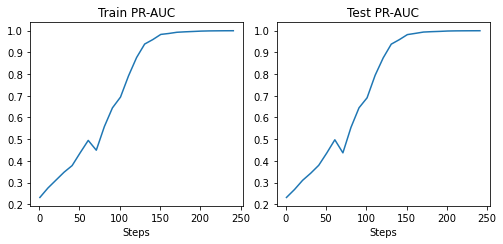

In [34]:
# Plot training and test objective as a function of steps.
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ax[0].plot(np.arange(1, num_steps + 1, 10), train_objectives)
ax[0].set_title('Train PR-AUC')
ax[0].set_xlabel('Steps')
ax[1].plot(np.arange(1, num_steps + 1, 10), test_objectives)
ax[1].set_title('Test PR-AUC')
ax[1].set_xlabel('Steps')
fig.tight_layout()

In [35]:
y_pred = model.predict(x_test)
pred_labels = np.argmax(y_pred, axis=1)
print(pred_labels, y_test)

precisions, recall, f1_score, true_sum = metrics.precision_recall_fscore_support(y_test, pred_labels)

print("Precision =", precisions)
print("Recall=", recall)
print("F1 Score =", f1_score)
accuracy_score = metrics.accuracy_score(y_test, pred_labels)
print('Accuracy' + str(accuracy_score))

[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]
Precision = [0.78687295 0.        ]
Recall= [1. 0.]
F1 Score = [0.88072624 0.        ]
Accuracy0.7868729488982653


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## (1b) ROC-AUC Training with Plain TF

In [36]:
# Create context with labels and predictions.
context = tfco.rate_context(logits_fn, labels_fn)

# Create optimization problem with PR-AUC as the objective. The library
# expects a minimization objective, so we negate the PR-AUC. 

# We use the roc_auc rate helper which uses a Riemann approximation to the area 
# under the precision-recall curve (recall on the horizontal axis, precision on 
# the vertical axis). We would need to specify the the number of bins 
# ("rectangles") to use for the Riemann approximation. We also can optionally
# specify the surrogate to be used to approximate the ROC-AUC
roc_auc_rate = tfco.roc_auc(
    context, bins=10, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
problem = tfco.RateMinimizationProblem(-roc_auc_rate)

In [37]:
# Create Lagrangian loss for `problem`. What we get back is a loss function, a 
# a nullary function that returns a list of update_ops that need to be run 
# before every gradient update, and the Lagrange multiplier variables internally
# maintained by the loss function. The argument `dual_scale` is a 
# hyper-parameter that specifies the relative importance placed on updates on 
# the Lagrange multipliers.
loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
    problem, dual_scale=1.0)

# Set up optimizer and the list of variables to optimize.
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
var_list = (model.trainable_weights + problem.trainable_variables + 
            [multipliers])

In [38]:
def roc_auc(model, features, labels):
    # Returns the ROC-AUC for given model, features and binary labels.
    scores = model.predict(features)
    return metrics.roc_auc_score(labels, scores)

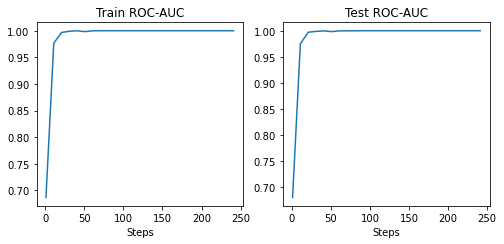

In [39]:
num_steps = 250
num_examples = x_train.shape[0]

train_objectives = []
test_objectives = []

for ii in range(num_steps):
  # Indices for current batch; cycle back once we reach the end of stream.
  batch_indices = np.arange(ii * batch_size, (ii + 1) * batch_size)
  batch_indices = [ind % num_examples for ind in batch_indices]

  # First run update ops, and then gradient update.
  update_ops_fn()
  optimizer.minimize(loss_fn, var_list=var_list)

  # Record train and test objectives once every 10 steps.
  if ii % 10 == 0:
    train_objectives.append(roc_auc(model, x_train, y_train))
    test_objectives.append(roc_auc(model, x_test, y_test))

# Plot training and test objective as a function of steps.
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ax[0].plot(np.arange(1, num_steps + 1, 10), train_objectives)
ax[0].set_title('Train ROC-AUC')
ax[0].set_xlabel('Steps')
ax[1].plot(np.arange(1, num_steps + 1, 10), test_objectives)
ax[1].set_title('Test ROC-AUC')
ax[1].set_xlabel('Steps')
fig.tight_layout()

# (1c) Accuracy Training with Plain TF

In [40]:
# from tensorflow_constrained_optimization.python.rates import loss
# DEFAULT_PENALTY_LOSS = loss.HingeLoss()
# DEFAULT_CONSTRAINT_LOSS = loss.ZeroOneLoss()

# Create context with labels and predictions.
context = tfco.rate_context(logits_fn, labels_fn)

# Create optimization problem with PR-AUC as the objective. The library
# expects a minimization objective, so we negate the Precision At Recall.

# We use the f1_score rate helper which uses a Riemann approximation to the area 
# under the precision-recall curve (recall on the horizontal axis, precision on 
# the vertical axis). We would need to specify the the number of bins 
# ("rectangles") to use for the Riemann approximation. We also can optionally
# specify the surrogate to be used to approximate the Precision At Recall.

accuracy_rate = tfco.accuracy_rate(
          context, 
            constraint_loss=tfco.SoftmaxCrossEntropyLoss())

In [41]:
problem = tfco.RateMinimizationProblem(-accuracy_rate)

In [42]:
# Create Lagrangian loss for `problem`. What we get back is a loss function, a 
# a nullary function that returns a list of update_ops that need to be run 
# before every gradient update, and the Lagrange multiplier variables internally
# maintained by the loss function. The argument `dual_scale` is a 
# hyper-parameter that specifies the relative importance placed on updates on 
# the Lagrange multipliers.
loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
    problem, dual_scale=1.0)

# Set up optimizer and the list of variables to optimize.
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
var_list = (model.trainable_weights + problem.trainable_variables + 
            [multipliers])

In [43]:
def accuracy(model, features, labels):
    # Returns the Accurracy for given model, features and binary labels.
    scores = np.argmax(model.predict(features), axis=1) 
    return metrics.accuracy_score(labels, scores)

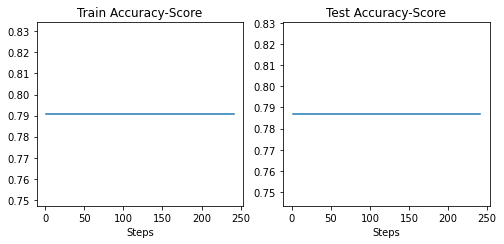

In [44]:
num_steps = 250
num_examples = x_train.shape[0]

train_objectives = []
test_objectives = []

for ii in range(num_steps):
  # Indices for current batch; cycle back once we reach the end of stream.
  batch_indices = np.arange(ii * batch_size, (ii + 1) * batch_size)
  batch_indices = [ind % num_examples for ind in batch_indices]

  # First run update ops, and then gradient update.
  update_ops_fn()
  optimizer.minimize(loss_fn, var_list=var_list)

  # Record train and test objectives once every 10 steps.
  if ii % 10 == 0:
    train_objectives.append(accuracy(model, x_train, y_train))
    test_objectives.append(accuracy(model, x_test, y_test))

# Plot training and test objective as a function of steps.
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ax[0].plot(np.arange(1, num_steps + 1, 10), train_objectives)
ax[0].set_title('Train Accuracy-Score')
ax[0].set_xlabel('Steps')
ax[1].plot(np.arange(1, num_steps + 1, 10), test_objectives)
ax[1].set_title('Test Accuracy-Score')
ax[1].set_xlabel('Steps')
fig.tight_layout()

# (1d) Precision, Recall and Accuracy Plain TF without Constraints

In [45]:
# Create linear Keras model.
layers = []
layers.append(tf.keras.Input(shape=(x_train.shape[-1],)))
layers.append(tf.keras.layers.Dense(32, activation='relu')) 
layers.append(tf.keras.layers.Dense(32, activation='relu')) 
layers.append(tf.keras.layers.Dense(1))
model = tf.keras.Sequential(layers)
model.summary()

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

#var_list = (
    #optimizer.trainable_variables())
    
# for ii in range(num_steps):
#   # Indices for current batch; cycle back once we reach the end of stream.
#   batch_indices = np.arange(ii * batch_size, (ii + 1) * batch_size)
#   batch_indices = [ind % num_examples for ind in batch_indices]
#   loss_fn =lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(
#       y_true, y_pred, from_logits=True)

#   #First run update ops, and then gradient update.
#   update_ops_fn()
#   optimizer.minimize(loss_fn, var_list=model.trainable_weights, y_true, y_pred)


loss = lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(
    y_true, y_pred, from_logits=True)

opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(optimizer=opt, loss=loss)
model.fit(x=x_train, y=y_train, batch_size=128, epochs=250)


y_pred = model.predict(x_test)
pred_labels = np.argmax(y_pred, axis=1)
print(pred_labels, y_test)



precisions, recall, f1_score, true_sum = metrics.precision_recall_fscore_support(y_test, pred_labels)

print("Precision =", precisions)
print("Recall=", recall)
print("F1 Score =", f1_score)
accuracy_score = metrics.accuracy_score(y_test, pred_labels)
print('Accuracy' + str(accuracy_score))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
167/167 [==============================] - 0s 547us/step - loss: 0.5739
Epoch 2/250
167/167 [==============================] - 0s 495us/step - loss: 0.3512
Epoch 3/250
167/167 [==============================] - 0s 504us/step - loss: 0.0806
Epoch 4/250
167/167 [==============================] - 0s 564us/step - loss: 0.0057
Epoch 5/250
167/167 [=========================

167/167 [==============================] - 0s 526us/step - loss: 2.6362e-05
Epoch 86/250
167/167 [==============================] - 0s 537us/step - loss: 2.5993e-05
Epoch 87/250
167/167 [==============================] - 0s 535us/step - loss: 2.5635e-05
Epoch 88/250
167/167 [==============================] - 0s 536us/step - loss: 2.5276e-05
Epoch 89/250
167/167 [==============================] - 0s 699us/step - loss: 2.4937e-05
Epoch 90/250
167/167 [==============================] - 0s 850us/step - loss: 2.4600e-05
Epoch 91/250
167/167 [==============================] - 0s 683us/step - loss: 2.4278e-05
Epoch 92/250
167/167 [==============================] - 0s 1ms/step - loss: 2.3950e-05
Epoch 93/250
167/167 [==============================] - 0s 751us/step - loss: 2.3643e-05
Epoch 94/250
167/167 [==============================] - 0s 709us/step - loss: 2.3344e-05
Epoch 95/250
167/167 [==============================] - 0s 815us/step - loss: 2.3034e-05
Epoch 96/250
167/167 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (2a) PR-AUC Training with Custom Estimators

We next show how one can use TFCO to optimize PR-AUC using custom tf.Estimators.

We first create `feature_columns` to convert the dataset into a format that can be processed by an estimator.

In [46]:
feature_columns = []
for feature_name in x_train_df.columns:
  feature_columns.append(
      tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

We next construct the input functions that return the data to be used by the estimator for training/evaluation.

In [47]:
def make_input_fn(
    data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_fn():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_fn

train_input_fn = make_input_fn(x_train_df, y_train_df, num_epochs=25)
test_input_fn = make_input_fn(x_test_df, y_test_df, num_epochs=1, shuffle=False)

We then write the model function that is used by the estimator to create the model, loss, optimizers and metrics.

In [48]:
def make_model_fn_pr_auc(feature_columns):
  # Returns model_fn.

  def model_fn(features, labels, mode):
    # Create model from features.
    layers = []
    layers.append(tf.keras.layers.DenseFeatures(feature_columns))
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    logits = model(features)

    # Baseline cross-entropy loss.
    baseline_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    baseline_loss = baseline_loss_fn(labels, logits)

    # As a slight variant from the above previous training, we will optimize a 
    # weighted combination of PR-AUC and the baseline loss.
    baseline_coef = 0.2
    
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      # Set up PR-AUC optimization problem.
      # Create context with labels and predictions.
      context = tfco.rate_context(logits, labels)

      # Create optimization problem with PR-AUC as the objective. The library
      # expects a minimization objective, so we negate the PR-AUC. We optimize
      # a convex combination of (negative) PR-AUC and the baseline loss (wrapped
      # in a rate object).
      pr_auc_rate = tfco.pr_auc(
          context, bins=10, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
      problem = tfco.RateMinimizationProblem(
          (1 - baseline_coef) * (-pr_auc_rate) + 
          baseline_coef * tfco.wrap_rate(baseline_loss))

      # Create Lagrangian loss for `problem`. What we get back is a loss 
      # function, a nullary function that returns a list of update_ops that 
      # need to be run before every gradient update, and the Lagrange 
      # multipliers maintained internally by the loss.
      # The argument `dual_scale` is a hyper-parameter that specifies the  
      # relative importance placed on updates on the Lagrange multipliers.
      loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
          problem, dual_scale=1.0)
      
      # Set up optimizer and the list of variables to optimize the loss.
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
      optimizer.iterations = tf.compat.v1.train.get_or_create_global_step()
      
      # Get minimize op and group with update_ops.
      var_list = (
          model.trainable_weights + problem.trainable_variables + [multipliers])
      minimize_op = optimizer.get_updates(loss_fn(), var_list)
      update_ops = update_ops_fn()
      train_op = tf.group(*update_ops, minimize_op)

    # Evaluate PR-AUC.
    pr_auc_metric = tf.keras.metrics.AUC(curve='PR')
    pr_auc_metric.update_state(labels, tf.sigmoid(logits))

    # We do not use the Lagrangian loss for evaluation/bookkeeping
    # purposes as it depends on some internal variables that may not be
    # set properly during evaluation time. We instead pass loss=baseline_loss.
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        predictions=logits, 
        loss=baseline_loss,
        train_op=train_op,
        eval_metric_ops={'PR-AUC': pr_auc_metric})
    
  return model_fn

In [49]:
# Create a temporary model directory.
model_dir = "tfco_tmp"
if os.path.exists(model_dir):
  shutil.rmtree(model_dir)

# Train estimator.
estimator_lin = tf.estimator.Estimator(
    make_model_fn_pr_auc(feature_columns), model_dir=model_dir)
estimator_lin.train(train_input_fn, steps=250) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tfco_tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (i

In [50]:
estimator_lin.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-08T11:33:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tfco_tmp/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.44148s
INFO:tensorflow:Finished evaluation at 2020-10-08-11:33:25
INFO:tensorflow:Saving dict for global step 250: PR-AUC = 0.9554919, global_step = 250, loss = 0.39580733
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250: tfco_tmp/model.ckpt-250


{'PR-AUC': 0.9554919, 'loss': 0.39580733, 'global_step': 250}

## (2b) ROC-AUC Training with Custom Estimators

In [51]:
def make_model_fn_roc_auc(feature_columns):
  # Returns model_fn.

  def model_fn(features, labels, mode):
    # Create model from features.
    layers = []
    layers.append(tf.keras.layers.DenseFeatures(feature_columns))
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    logits = model(features)

    # Baseline cross-entropy loss.
    baseline_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    baseline_loss = baseline_loss_fn(labels, logits)

    # As a slight variant from the above previous training, we will optimize a 
    # weighted combination of ROC-AUC and the baseline loss.
    baseline_coef = 0.2
    
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      # Set up ROC-AUC optimization problem.
      # Create context with labels and predictions.
      context = tfco.rate_context(logits, labels)

      # Create optimization problem with ROC-AUC as the objective. The library
      # expects a minimization objective, so we negate the PR-AUC. We optimize
      # a convex combination of (negative) ROC-AUC and the baseline loss (wrapped
      # in a rate object).
      roc_auc_rate = tfco.roc_auc(
          context, bins=10, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
      problem = tfco.RateMinimizationProblem(
          (1 - baseline_coef) * (-roc_auc_rate) + 
          baseline_coef * tfco.wrap_rate(baseline_loss))

      # Create Lagrangian loss for `problem`. What we get back is a loss 
      # function, a nullary function that returns a list of update_ops that 
      # need to be run before every gradient update, and the Lagrange 
      # multipliers maintained internally by the loss.
      # The argument `dual_scale` is a hyper-parameter that specifies the  
      # relative importance placed on updates on the Lagrange multipliers.
      loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
          problem, dual_scale=1.0)
      
      # Set up optimizer and the list of variables to optimize the loss.
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
      optimizer.iterations = tf.compat.v1.train.get_or_create_global_step()
      
      # Get minimize op and group with update_ops.
      var_list = (
          model.trainable_weights + problem.trainable_variables + [multipliers])
      minimize_op = optimizer.get_updates(loss_fn(), var_list)
      update_ops = update_ops_fn()
      train_op = tf.group(*update_ops, minimize_op)

    # Evaluate ROC-AUC.
    roc_auc_metric = tf.keras.metrics.AUC(curve='ROC')
    roc_auc_metric.update_state(labels, tf.sigmoid(logits))

    # We do not use the Lagrangian loss for evaluation/bookkeeping
    # purposes as it depends on some internal variables that may not be
    # set properly during evaluation time. We instead pass loss=baseline_loss.
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        predictions=logits, 
        loss=baseline_loss,
        train_op=train_op,
        eval_metric_ops={'ROC-AUC': roc_auc_metric})
    
  return model_fn

We are now ready to train the estimator.

In [52]:
# Create a temporary model directory.
model_dir = "tfco_tmp"
if os.path.exists(model_dir):
  shutil.rmtree(model_dir)

# Train estimator.
estimator_lin = tf.estimator.Estimator(
    make_model_fn_roc_auc(feature_columns), model_dir=model_dir)
estimator_lin.train(train_input_fn, steps=250) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tfco_tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_f

Finally, we evaluate the trained model on the test set.

In [53]:
estimator_lin.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-08T11:33:34Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tfco_tmp/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.45977s
INFO:tensorflow:Finished evaluation at 2020-10-08-11:33:34
INFO:tensorflow:Saving dict for global step 250: ROC-AUC = 0.9972118, global_step = 250, loss = 0.42947346
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250: tfco_tmp/model.ckpt-250


{'ROC-AUC': 0.9972118, 'loss': 0.42947346, 'global_step': 250}

## Closing Remarks

Before closing, we point out that there are three main hyper-paramters you may want to tune to improve the PR-AUC training:

- `learning_rate`
- `dual_scale`
- `baseline_coeff`

We may also be interested in exploring helpers for other similar metrics that TFCO allows you to optimize: Lets expore them in the beneatah cells.
- `tfco.precision_at_recall`
- `tfco.recall_at_precision`
- `tfco.inverse_precision_at_recall`

# (2c) Precision_At_Recall Training with Custom Estimators

In [54]:
def make_model_fn_precision_at_recall(feature_columns):
  # Returns model_fn.

  def model_fn(features, labels, mode):
    # Create model from features.
    layers = []
    layers.append(tf.keras.layers.DenseFeatures(feature_columns))
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    logits = model(features)

    # Baseline cross-entropy loss.
    baseline_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    baseline_loss = baseline_loss_fn(labels, logits)

    # As a slight variant from the above previous training, we will optimize a 
    # weighted combination of Precision At Recall and the baseline loss.
    baseline_coef = 0.2
    
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      # Set up ROC-AUC optimization problem.
      # Create context with labels and predictions.
      context = tfco.rate_context(logits, labels)

      # Create optimization problem with Precision At Recall as the objective. The library
      # expects a minimization objective, so we negate the Precision At Recall. We optimize
      # a convex combination of (negative) Precision At Recall and the baseline loss (wrapped
      # in a rate object).
      precision_at_recall_rate = tfco.precision_at_recall(
          context, recall_target=0.9, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
      problem = tfco.RateMinimizationProblem(
          (1 - baseline_coef) * (-precision_at_recall_rate) + 
          baseline_coef * tfco.wrap_rate(baseline_loss))

      # Create Lagrangian loss for `problem`. What we get back is a loss 
      # function, a nullary function that returns a list of update_ops that 
      # need to be run before every gradient update, and the Lagrange 
      # multipliers maintained internally by the loss.
      # The argument `dual_scale` is a hyper-parameter that specifies the  
      # relative importance placed on updates on the Lagrange multipliers.
      loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
          problem, dual_scale=1.0)
      
      # Set up optimizer and the list of variables to optimize the loss.
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
      optimizer.iterations = tf.compat.v1.train.get_or_create_global_step()
      
      # Get minimize op and group with update_ops.
      var_list = (
          model.trainable_weights + problem.trainable_variables + [multipliers])
      minimize_op = optimizer.get_updates(loss_fn(), var_list)
      update_ops = update_ops_fn()
      train_op = tf.group(*update_ops, minimize_op)

    # Evaluate Precision At Recall.
    precision_at_recall_metric = tf.keras.metrics.PrecisionAtRecall(0.6)
    precision_at_recall_metric.update_state(labels, tf.sigmoid(logits))

    # We do not use the Lagrangian loss for evaluation/bookkeeping
    # purposes as it depends on some internal variables that may not be
    # set properly during evaluation time. We instead pass loss=baseline_loss.
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        predictions=logits, 
        loss=baseline_loss,
        train_op=train_op,
        eval_metric_ops={'Precision-At-Recall': precision_at_recall_metric})
    
  return model_fn

In [55]:
# Create a temporary model directory.
model_dir = "tfco_tmp"
if os.path.exists(model_dir):
  shutil.rmtree(model_dir)

# Train estimator.
estimator_lin = tf.estimator.Estimator(
    make_model_fn_precision_at_recall(feature_columns), model_dir=model_dir)
estimator_lin.train(train_input_fn, steps=250) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tfco_tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_f

In [56]:
estimator_lin.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-08T11:33:37Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tfco_tmp/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.38415s
INFO:tensorflow:Finished evaluation at 2020-10-08-11:33:37
INFO:tensorflow:Saving dict for global step 250: Precision-At-Recall = 0.99945563, global_step = 250, loss = 0.5915339
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250: tfco_tmp/model.ckpt-250


{'Precision-At-Recall': 0.99945563, 'loss': 0.5915339, 'global_step': 250}

## (2d) Recall_At_Precision Training with Custom Estimators

In [57]:
def make_model_fn_recall_at_precision(feature_columns):
  # Returns model_fn.

  def model_fn(features, labels, mode):
    # Create model from features.
    layers = []
    layers.append(tf.keras.layers.DenseFeatures(feature_columns))
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    logits = model(features)

    # Baseline cross-entropy loss.
    baseline_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    baseline_loss = baseline_loss_fn(labels, logits)

    # As a slight variant from the above previous training, we will optimize a 
    # weighted combination of Precision At Recall and the baseline loss.
    baseline_coef = 0.2
    
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      # Set up ROC-AUC optimization problem.
      # Create context with labels and predictions.
      context = tfco.rate_context(logits, labels)

      # Create optimization problem with Recall-At-Precision as the objective. The library
      # expects a minimization objective, so we negate the Recall-At-Precision. We optimize
      # a convex combination of (negative) Recall-At-Precision and the baseline loss (wrapped
      # in a rate object).
      recall_at_precision_rate = tfco.recall_at_precision(
          context, precision_target=0.9, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
      problem = tfco.RateMinimizationProblem(
          (1 - baseline_coef) * (-recall_at_precision_rate) + 
          baseline_coef * tfco.wrap_rate(baseline_loss))

      # Create Lagrangian loss for `problem`. What we get back is a loss 
      # function, a nullary function that returns a list of update_ops that 
      # need to be run before every gradient update, and the Lagrange 
      # multipliers maintained internally by the loss.
      # The argument `dual_scale` is a hyper-parameter that specifies the  
      # relative importance placed on updates on the Lagrange multipliers.
      loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
          problem, dual_scale=1.0)
      
      # Set up optimizer and the list of variables to optimize the loss.
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
      optimizer.iterations = tf.compat.v1.train.get_or_create_global_step()
      
      # Get minimize op and group with update_ops.
      var_list = (
          model.trainable_weights + problem.trainable_variables + [multipliers])
      minimize_op = optimizer.get_updates(loss_fn(), var_list)
      update_ops = update_ops_fn()
      train_op = tf.group(*update_ops, minimize_op)

    # Evaluate Recall At Precision.
    recall_at_precision_metric = tf.keras.metrics.RecallAtPrecision(0.6)
    recall_at_precision_metric.update_state(labels, tf.sigmoid(logits))

    # We do not use the Lagrangian loss for evaluation/bookkeeping
    # purposes as it depends on some internal variables that may not be
    # set properly during evaluation time. We instead pass loss=baseline_loss.
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        predictions=logits, 
        loss=baseline_loss,
        train_op=train_op,
        eval_metric_ops={'Recall-At-Precision': recall_at_precision_metric})
    
  return model_fn

In [58]:
# Create a temporary model directory.
model_dir = "tfco_tmp"
if os.path.exists(model_dir):
  shutil.rmtree(model_dir)

# Train estimator.
estimator_lin = tf.estimator.Estimator(
    make_model_fn_recall_at_precision(feature_columns), model_dir=model_dir)
estimator_lin.train(train_input_fn, steps=250) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tfco_tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_f

In [59]:
estimator_lin.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-08T11:33:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tfco_tmp/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.35913s
INFO:tensorflow:Finished evaluation at 2020-10-08-11:33:40
INFO:tensorflow:Saving dict for global step 250: Recall-At-Precision = 1.0, global_step = 250, loss = 0.19825907
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250: tfco_tmp/model.ckpt-250


{'Recall-At-Precision': 1.0, 'loss': 0.19825907, 'global_step': 250}